In [40]:
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [2]:
raw_image_path = '/app/datasets/interpolation.png'
raw_image = cv2.imread(raw_image_path)

In [7]:
result_dataset_path = Path('/app/datasets/interpolation')
result_dataset_path.mkdir(exist_ok=True)
id_to_images = {id: [] for id in range(3)}
for i in range(3):
    out_path = result_dataset_path / str(i)
    out_path.mkdir(exist_ok=True)
    for j in range(9):
        crop_image = raw_image[i * 256: (i + 1) * 256, j * 256: (j + 1) * 256]
        id_to_images[i].append(crop_image)
        cv2.imwrite(str(out_path / (str(j).zfill(4)+'.jpg')), crop_image)


### Get embeddings

In [32]:
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"],
    root="./data/insightface",
)
app.prepare(ctx_id=0, det_size=(256, 256))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./data/insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (256, 256)


In [37]:
id_to_embs = {id: [] for id in range(3)}
for id in id_to_images:
    out_path = result_dataset_path / str(id)
    for j in range(9):
        #image_path = str(out_path / (str(j).zfill(4)+'.jpg'))
        #image = cv2.imread(image_path)[:,:,::-1]
        image = id_to_images[id][j]
        faces = app.get(image)
        assert len(faces) == 1, j
        id_to_embs[id].append(faces[0]['embedding'])

/home/erlygin/miniconda/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


### Create gallery and compute 

In [39]:
from evaluation.open_set_methods.posterior_prob_based import PosteriorProb
class_model = 'power'

estimator = PosteriorProb(kappa=0.3, beta=0.5, class_model=class_model, K=2, kappa_is_tau=True)

Tau 0.3, kappa 363.52


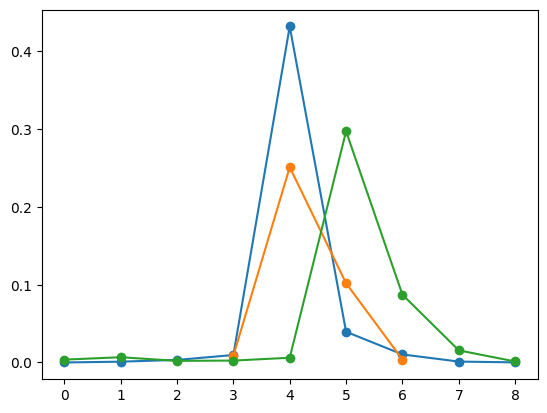

In [71]:
# compute similarity matrix
test_id = 0
for test_id in range(3):
    first_gallery_emb = id_to_embs[test_id][0]
    second_gallery_emb = id_to_embs[test_id][-1]
    gallery_embeddings = np.concatenate([first_gallery_emb[np.newaxis,:], second_gallery_emb[np.newaxis,:]])
    probe_embeddings = []
    for j in np.arange(0, 9):
        probe_embeddings.append(id_to_embs[test_id][j])

    probe_embeddings = np.array(probe_embeddings)
    similarity_matrix = probe_embeddings @ gallery_embeddings.T

    import torch
    probabilities = torch.exp(estimator.compute_all_class_log_probabilities(torch.tensor(similarity_matrix))).numpy()

    plt.plot(np.arange(9), -np.max(probabilities, axis=1) + 1, marker='o')

(9, 2)

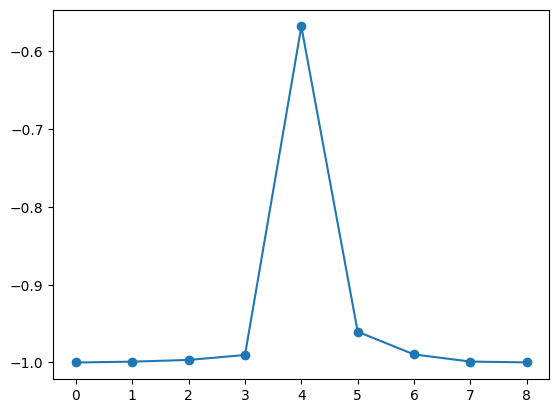